In [ ]:
import os
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'

In [ ]:
import cv2

cap = cv2.VideoCapture("../data/yulia_sochi_free.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Video frame rate: {fps} FPS")

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames: {frame_count}")

        
cap.release()

Video frame rate: 25.030266343825666 FPS
Total frames: 827


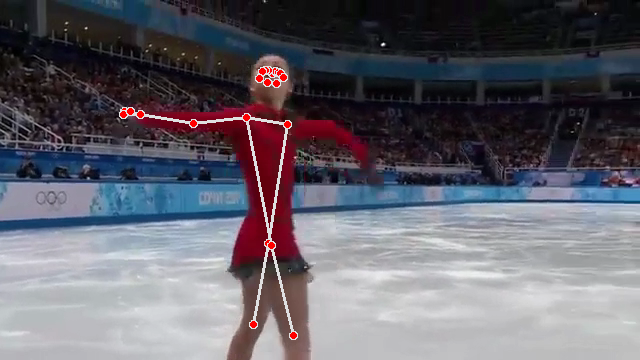

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
from IPython.display import display, clear_output, Image

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture("../data/yulia_sochi_free.mp4")

try:
    with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = holistic.process(frame_rgb)

            if results.pose_landmarks:
                mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                
            _, img = cv2.imencode('.png', frame)
            display(Image(data=img.tobytes()))
            clear_output(wait=True)
finally:
    cap.release()

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
from IPython.display import display, clear_output, Image
from tqdm.notebook import tqdm

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture("../data/yulia_sochi_free.mp4")

# Get total number of frames to show the progress bar
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

landmarks_data = []

try:
    with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
        frame_idx = 0  # Initialize frame index
        # Initialize tqdm for progress bar
        for _ in tqdm(range(total_frames), desc="Processing frames", unit="frame"):
            ret, frame = cap.read()

            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)

            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for landmark_idx, landmark in enumerate(landmarks):
                    landmarks_data.append({
                        'frame': frame_idx,  # Add frame index directly
                        'landmark_idx': landmark_idx,  # Add landmark index
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })

            frame_idx += 1  # Increment frame index

finally:
    cap.release()

# Convert the landmarks data into a DataFrame
df = pd.DataFrame(landmarks_data)

print(df)

In [24]:
df.to_pickle("../data/raw_coordinates.pkl.xz")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_pickle("../data/raw_coordinates.pkl.xz")

blacklist_landmark_indexes = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, # all face indexes
    17, 18, 19, 20, 21, 22, # left and right fingers and thumb
    29, 30, 31, 32 # left and right toes and heel
]

df = df.loc[
    ~df.landmark_idx.isin(blacklist_landmark_indexes)
].reset_index(drop = True)

In [41]:
df_13 = df.loc[df.landmark_idx == 13]
df_15 = df.loc[df.landmark_idx == 15]

merged_13_15 = df_13.merge(df_15, on = "frame", suffixes = ("_13", "_15")).drop(columns = ["landmark_idx_13", "landmark_idx_15"])
merged_13_15["dx"] = merged_13_15.x_13 - merged_13_15.x_15
merged_13_15["dy"] = merged_13_15.y_13 - merged_13_15.y_15
merged_13_15["dz"] = merged_13_15.z_13 - merged_13_15.z_15

merged_13_15["l"] = merged_13_15.apply(lambda s: np.sqrt(np.square(s.dx) + np.square(s.dy) + np.square(s.dz)), axis = 1)

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=merged_13_15["frame"], y=merged_13_15["l"], mode='lines', name='Euclidean Distance between landmark 13 and 15'))
fig.add_trace(go.Scatter(x=merged_13_15["frame"], y=merged_13_15["visibility_13"], mode='lines', name='Visibility of landmark 13'))
fig.add_trace(go.Scatter(x=merged_13_15["frame"], y=merged_13_15["visibility_15"], mode='lines', name='Visibility of landmark 15'))

fig.update_layout(
    title="Euclidean Distance Between Landmark 13 and Landmark 15 Over Time",
    xaxis_title="Frame",
    yaxis_title="Distance (l)",
    showlegend=True
)


fig.show()

merged_13_15

,frame,x_13,y_13,z_13,visibility_13,x_15,y_15,z_15,visibility_15,dx,dy,dz,l
0,0,0.463570,0.342382,-0.122531,0.991035,0.486945,0.412005,-0.257267,0.987842,-0.023375,-0.069624,0.134736,0.153452
1,1,0.477820,0.344769,-0.147562,0.991781,0.515059,0.396707,-0.265420,0.988682,-0.037239,-0.051938,0.117858,0.134070
2,2,0.501086,0.347203,-0.286549,0.992561,0.546799,0.381440,-0.388474,0.989713,-0.045713,-0.034237,0.101925,0.116835
3,3,0.514813,0.347150,-0.205267,0.993234,0.559295,0.366398,-0.319937,0.990589,-0.044482,-0.019248,0.114669,0.124492
4,4,0.519945,0.347232,-0.091325,0.993674,0.556334,0.357818,-0.190560,0.991289,-0.036389,-0.010586,0.099235,0.106225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,821,0.454902,0.469902,0.195212,0.374967,0.472099,0.553908,0.052302,0.168360,-0.017197,-0.084005,0.142910,0.166661
784,822,0.452207,0.467415,0.190030,0.340530,0.470608,0.539592,0.059099,0.155431,-0.018401,-0.072177,0.130931,0.150635
785,823,0.500745,0.435770,0.192442,0.336687,0.521218,0.522449,0.105874,0.182524,-0.020473,-0.086679,0.086568,0.124203
786,824,0.514948,0.405264,0.228159,0.371790,0.540927,0.479016,0.258343,0.246471,-0.025979,-0.073753,-0.030184,0.083818


In [5]:
minimum_visibility       = 0.5
rolling_mean_window_size = 5

l = []

for i, landmark_index in enumerate(df.landmark_idx.unique()):
    subset_df = df.loc[df.landmark_idx == landmark_index]

    template = pd.Series(np.arange(df.frame.max() + 1), name = "frame")

    subset_df = subset_df.merge(template, on = "frame", how = "outer")

    subset_df.landmark_idx = subset_df.landmark_idx.fillna(landmark_index).astype(int)

    subset_df.loc[subset_df.visibility < minimum_visibility, ["x", "y", "z"]] = np.nan

    subset_df.x = subset_df.x.rolling(window = rolling_mean_window_size, min_periods = 1, center = True).mean()
    subset_df.y = subset_df.y.rolling(window = rolling_mean_window_size, min_periods = 1, center = True).mean()
    subset_df.z = subset_df.z.rolling(window = rolling_mean_window_size, min_periods = 1, center = True).mean()

    l.append(subset_df)

cleaned_landmarks_df = pd.concat(l)

In [29]:
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

minimum_visibility = 0.9

l = []

for _, landmark_index in tqdm(enumerate(df.landmark_idx.unique())):
    subset_df = df.loc[df.landmark_idx == landmark_index]

    template = pd.Series(np.arange(df.frame.max() + 1), name="frame")
    subset_df = subset_df.merge(template, on="frame", how="outer")
    
    subset_df.landmark_idx = subset_df.landmark_idx.fillna(landmark_index).astype(int)

    # Set coordinates to NaN if visibility is below threshold
    subset_df.loc[subset_df.visibility < minimum_visibility, ["x", "y", "z"]] = np.nan

    # Function to apply spline interpolation
    def spline_interpolate(series):
        valid = ~series.isna()
        if valid.sum() > 1:  # Only interpolate if we have enough points
            interp = interp1d(series.index[valid], series.dropna(), kind="cubic", fill_value="extrapolate")
            return pd.Series(interp(series.index), index=series.index)
        return series  # Return original if not enough valid data

    # Apply spline interpolation
    subset_df["x"] = spline_interpolate(subset_df["x"])
    subset_df["y"] = spline_interpolate(subset_df["y"])
    subset_df["z"] = spline_interpolate(subset_df["z"])

    l.append(subset_df)

cleaned_landmarks_df = pd.concat(l)


0it [00:00, ?it/s]

In [31]:
# import time
# import cv2
# import mediapipe as mp
# import pandas as pd
# from IPython.display import display, clear_output, Image
# from mediapipe.framework.formats import landmark_pb2

# mp_holistic = mp.solutions.holistic
# mp_drawing = mp.solutions.drawing_utils

# cap = cv2.VideoCapture("../data/yulia_sochi_free.mp4")

# fps = cap.get(cv2.CAP_PROP_FPS)
# print(f"Video frame rate: {fps} FPS")

# # desired_fps = 10
# desired_fps = 25
# frame_delay = max([0, 1.0 / desired_fps])

# try:
#     with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
#         while cap.isOpened():
#             ret, frame = cap.read()
            
#             if not ret:
#                 break

#             current_frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

#             subset_df = cleaned_landmarks_df.loc[cleaned_landmarks_df.frame == current_frame_idx]

#             landmark_list = landmark_pb2.NormalizedLandmarkList()

#             for _, row in subset_df.iterrows():
#                 normalized_landmark = landmark_pb2.NormalizedLandmark()

#                 normalized_landmark.x = row.x
#                 normalized_landmark.y = row.y
#                 normalized_landmark.z = row.z
#                 normalized_landmark.visibility = row.visibility
                
#                 landmark_list.landmark.add().CopyFrom(normalized_landmark)

#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#             results = holistic.process(frame_rgb)
            
#             if len(landmark_list.landmark) > 0:
#                 mp_drawing.draw_landmarks(frame, landmark_list)

#             _, img = cv2.imencode('.png', frame)
#             display(Image(data=img.tobytes()))
#             clear_output(wait=True)

#             time.sleep(frame_delay)
# finally:
#     cap.release()


In [18]:
# import time
# import cv2
# import mediapipe as mp
# import pandas as pd
# import numpy as np
# from IPython.display import display, clear_output, Image
# from mediapipe.framework.formats import landmark_pb2

# mp_holistic = mp.solutions.holistic
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles

# cap = cv2.VideoCapture("../data/yulia_sochi_free.mp4")

# fps = cap.get(cv2.CAP_PROP_FPS)
# print(f"Video frame rate: {fps} FPS")

# desired_fps = 10
# frame_delay = 1.0 / desired_fps

# left_colour  = (255, 0, 0)
# right_colour = (0, 255, 0)

# landmark_colors = {
#     11: left_colour,
#     13: left_colour,
#     15: left_colour,
#     23: left_colour,
#     25: left_colour,
#     27: left_colour,
#     12: right_colour,
#     14: right_colour,
#     16: right_colour,
#     24: right_colour,
#     26: right_colour,
#     28: right_colour
# }


# pose_landmark_style = mp_drawing_styles.get_default_pose_landmarks_style()
# for landmark_idx, colour in landmark_colors.items():
#     pose_landmark_style[landmark_idx] = mp_drawing.DrawingSpec(color=colour, thickness=2, circle_radius=3)

# try:
#     with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
#         while cap.isOpened():
#             ret, frame = cap.read()
            
#             if not ret:
#                 break

#             current_frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

#             subset_df = cleaned_landmarks_df.loc[cleaned_landmarks_df.frame == current_frame_idx]

#             landmark_list = landmark_pb2.NormalizedLandmarkList()

#             for _, row in subset_df.iterrows():
#                 normalized_landmark = landmark_pb2.NormalizedLandmark()
#                 normalized_landmark.x = row.x
#                 normalized_landmark.y = row.y
#                 normalized_landmark.z = row.z
#                 normalized_landmark.visibility = row.visibility
                
#                 landmark_list.landmark.add().CopyFrom(normalized_landmark)

#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#             results = holistic.process(frame_rgb)

#             if len(landmark_list.landmark) > 0:
#                 mp_drawing.draw_landmarks(
#                     frame, 
#                     landmark_list, 
#                     landmark_drawing_spec=pose_landmark_style
#                 )

#             _, img = cv2.imencode('.png', frame)
#             display(Image(data=img.tobytes()))
#             clear_output(wait=True)

#             time.sleep(frame_delay)
# finally:
#     cap.release()
